# Initial experiment: small vanilla transformer (NanoGPT) trained on plain addition

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import math

import torch
from torch import nn, Tensor

from arithmetic_lm.utils import get_torch_device, set_seed

In [3]:
DEVICE = get_torch_device()
print(f"Using device: {DEVICE}")

set_seed(1337)

Using device: mps


## NanoGPT model

In [4]:
# from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int, dropout: float):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [5]:
class TinyTransformer(nn.Module):
    """Simple small decoder-only transformer model using nn.TransformerDecoder."""

    def __init__(
        self,
        context_len: int,
        n_embd: int,
        n_head: int,
        n_layers: int,
        vocab_size: int,
        ff_factor: int = 4,
        dropout: float = 0.1,
    ):
        """
        Arguments:
            context_len: context length, i.e. the number of expected features in the input
            n_embd: dimensionality of model embeddings
            n_head: number of heads in the multi-head attention
            n_layers: number of nn.TransformerDecoderLayer layers
            vocab_size: size of the vocabulary
            ff_factor: factor by which to scale the hidden layer dimensionality in the feedforward layer
            dropout: dropout probability
        """

        super().__init__()
        self.context_len = context_len
        self.n_embd = n_embd
        self.n_head = n_head
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        self.ff_factor = ff_factor
        self.dropout = dropout

        # Embedding
        self.embedding = nn.Embedding(vocab_size, n_embd)
        self.pos_encoder = PositionalEncoding(n_embd, max_len=context_len, dropout=dropout)

        # Same as decoder layer essentially, but without cross attention
        self.layer = nn.TransformerEncoderLayer(
            d_model=n_embd,
            nhead=n_head,
            dim_feedforward=n_embd * ff_factor,
            dropout=dropout,

        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.layer,
            num_layers=n_layers,
            norm=nn.LayerNorm(n_embd),
        )

        # Output
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
    
    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size]``
        """
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x, is_causal=True, mask=torch.nn.Transformer.generate_square_subsequent_mask(self.context_len))
        x = self.lm_head(x)
        return x
    
    @torch.no_grad()
    def generate(self, idx: Tensor, max_new_tokens: int, temperature: float = 1.0, top_k: int = None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (seq_len, batch)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # crop to context_len if necessary
            idx_cond = idx if idx.size(0) <= self.context_len else idx[-self.context_len:, :]
            logits = self.forward(idx_cond)
            # get logits at final step and apply temperature
            logits = logits[-1:, :, :] / temperature
            # optionally apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(0)), dim=-1)
                logits[logits < v[:, :, [-1]]] = -float("inf")
            # apply softmax
            probs = torch.nn.functional.softmax(logits, dim=-1)
            # sample from the distribution
            next_token = torch.multinomial(probs[0], num_samples=1)
            # append to the sequence
            idx = torch.cat([idx, next_token], dim=0)
        return idx

In [6]:
net = TinyTransformer(
    context_len=10,
    n_embd=32,
    n_head=4,
    n_layers=2,
    vocab_size=100,
    ff_factor=4,
    dropout=0.1,
).to(DEVICE)

# test forward pass
x = torch.randint(0, 100, (10, 8)).to(DEVICE) # (seq_len, batch_size)
y = net(x)
y.shape # (seq_len, batch_size, vocab_size)

/Users/imran/Library/Caches/pypoetry/virtualenvs/msc-thesis-P7I560r2-py3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([10, 8, 100])

## Test one batch overfitting

In [7]:
from arithmetic_lm.tokenizer import CharTokenizer

In [8]:
tokenizer = CharTokenizer()

In [9]:
text = "hello worl"
tokens = tokenizer.encode(text)
tokens, "len:", len(tokens), tokenizer.decode(tokens)

([17, 14, 21, 21, 24, 94, 32, 24, 27, 21], 'len:', 10, 'hello worl')

In [10]:
# convert to tensor
tokens = torch.tensor(tokens).unsqueeze(1).to(DEVICE)
tokens.shape

torch.Size([10, 1])

In [11]:
y.view(-1, y.size(-1)).shape, tokens.view(-1)

(torch.Size([80, 100]),
 tensor([17, 14, 21, 21, 24, 94, 32, 24, 27, 21], device='mps:0'))

In [12]:
# simplest train loop
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# create target by shifting tokens by 1 and adding a padding token at the end
target = torch.cat([tokens[1:, 0], torch.tensor([65]).to(DEVICE)]).unsqueeze(-1)

losses = []

for i in range(1000):
    optimizer.zero_grad()
    y = net(tokens)
    loss = criterion(y.view(-1, y.size(-1)), target.view(-1))
    loss.backward()
    optimizer.step()
    print(f"[{i}] loss: {loss.item():.5f}")
    losses.append(loss.item())

[0] loss: 4.75054
[1] loss: 4.84614
[2] loss: 4.44716
[3] loss: 4.58616
[4] loss: 4.19507
[5] loss: 4.10802
[6] loss: 3.93403
[7] loss: 3.71056
[8] loss: 3.73026
[9] loss: 3.62177
[10] loss: 3.49763
[11] loss: 3.39667
[12] loss: 3.31937
[13] loss: 3.23069
[14] loss: 3.19946
[15] loss: 3.01413
[16] loss: 3.04749
[17] loss: 2.98443
[18] loss: 2.93788
[19] loss: 2.84480
[20] loss: 2.77242
[21] loss: 2.74176
[22] loss: 2.71742
[23] loss: 2.65807
[24] loss: 2.60152
[25] loss: 2.56191
[26] loss: 2.46438
[27] loss: 2.33367
[28] loss: 2.21808
[29] loss: 2.26809
[30] loss: 2.14971
[31] loss: 2.16049
[32] loss: 2.10479
[33] loss: 2.03912
[34] loss: 2.05508
[35] loss: 1.92739
[36] loss: 1.92850
[37] loss: 1.90222
[38] loss: 1.83010
[39] loss: 1.75390
[40] loss: 1.82884
[41] loss: 1.69540
[42] loss: 1.65533
[43] loss: 1.66301
[44] loss: 1.57256
[45] loss: 1.58017
[46] loss: 1.51742
[47] loss: 1.51938
[48] loss: 1.45002
[49] loss: 1.37712
[50] loss: 1.34487
[51] loss: 1.33578
[52] loss: 1.34706
[53

Text(0, 0.5, 'loss')

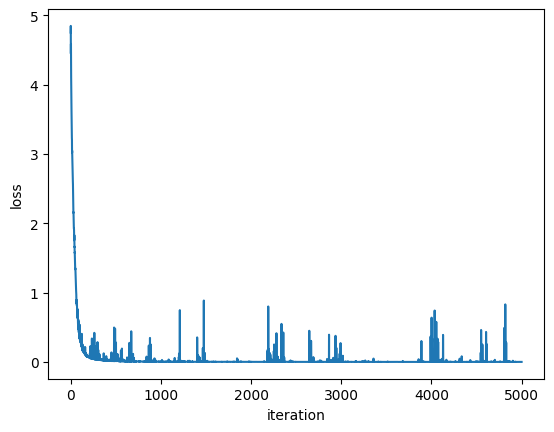

In [13]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")

In [14]:
test_prompt = "hell"
tokens = tokenizer.encode(test_prompt)
tokens = torch.tensor(tokens).unsqueeze(1).to(DEVICE)
print(tokens.shape)

net.eval()
generated_tokens = net.generate(tokens, max_new_tokens=10, temperature=1.0, top_k=10)

tokenizer.decode(generated_tokens.squeeze(1).cpu().numpy())

torch.Size([4, 1])


'hello worl$$$$'